## Classificação dos dígitos 0, 1, 4 e 5 usando os 3 principais modelos lineares (Perceptron, Regressão Linear e Regressão Logística)

### Alunos: João Paulo do Nascimento Borges e Tales Nobre Leite Dias de Oliveira

### Descrição das atividades 

Implementar três classificadores de dígitos contidos no dataset MNIST, utilizando os três modelos lineares de Aprendizagem de Máquina (AM) estudados: Perceptron, Regressão Linear e Regressão Logística. Detalhes da implementação estão descritas a seguir.

### Importando as bibliotecas

In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import linalg as LA
from models import *
from metrics import *
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

### Intensidade das imagens

Como os pixel mais escuros possuem valores maiores (255 representa o preto), a
intensidade de uma imagem pode ser calculada pela equação:

$$ I = \frac{\sum_{x=0}^{783}𝑝𝑖𝑥𝑒𝑙x} {255} $$

que soma os tons de cinza de cada pixel e divide por 255, tentando uma aproximação da
quantidade de pixels pretos na imagem.

In [2]:
def calc_intensity(image):
    return np.sum(image) / 255

### Simetria da imagem

A simetria vertical deve ser computada linha por linha. Em cada linha soma-se a
diferença em módulo do valor do pixel da primeira coluna com o valor da última, da
segunda com a penúltima, terceira com a antepenúltima e assim por diante.
Seja $pix_{28𝑥28}$ a matriz de valores dos pixels da imagem, então, temos a equação:

$$ S_v = \frac{\sum_{i=0}^{27}\sum_{j=0}^{13} \left \| pix_{i,j} - pix_{i,27-j} \right \| }{255} $$

para a simetria vertical. O valor de $𝑆_𝑣$ define uma aproximação da quantidade de pixels
pretos assimétricos. Ou seja, quando $𝑆_𝑣 = 0$, a imagem possui simetria vertical perfeita.

In [3]:
def calc_symmetry_v(image):
    sym_v = 0
    for i in range(28):
        for j in range(14):
            sym_v += abs(image[i][j] - image[i][27-j])
    return sym_v / 255

A simetria horizontal é análoga a simetria vertical, sendo que o eixo horizontal divide
as linhas da matriz pelo meio, criando duas partes, superior e inferior. Nesse caso, a
diferença de valores entre os pixels é computada de cima para baixo. Logo, através de
algumas adaptações da equação da simetria vertical, é possível computar o $𝑆_h$ e, por fim,
somar ao $𝑆_𝑣$  e obter o valor de simetria da imagem completa.
Nesta atividade, deve-se construir novos arquivos de treino e teste a serem chamados
de train_redu.csv e test_redu.csv. Esses arquivos conterão 3 as seguintes colunas: label,
intensidade e simetria. 

In [4]:
def calc_symmetry_h(image):
    sym_h = 0
    for j in range(28):
        for i in range(14):
            sym_h += abs(image[i][j] - image[27-i][j])
    return sym_h / 255

### Redução da dimensão das amostras

Carrega os arquivos de treino e teste

In [5]:
train_df = pd.read_csv('data/train.csv', sep=";")
test_df = pd.read_csv('data/test.csv', sep=";")

Extrai as imagens e as labels dos arquivos de treino e teste

In [6]:
train_images = train_df.iloc[:, 1:].to_numpy().reshape((-1, 28, 28))
test_images = test_df.iloc[:, 1:].to_numpy().reshape((-1, 28, 28))
train_labels = train_df.iloc[:, 0].to_numpy()
test_labels = test_df.iloc[:, 0].to_numpy()

Calcula a intensidade e a simetria de cada imagem dos arquivos de treino e teste

In [7]:
train_intensity = np.array([calc_intensity(image) for image in train_images])
train_symmetry_v = np.array([calc_symmetry_v(image) for image in train_images])
train_symmetry_h = np.array([calc_symmetry_h(image) for image in train_images])
test_intensity = np.array([calc_intensity(image) for image in test_images])
test_symmetry_v = np.array([calc_symmetry_v(image) for image in test_images])
test_symmetry_h = np.array([calc_symmetry_h(image) for image in test_images])

In [8]:
train_redu_df = pd.DataFrame({
    'label': train_labels,
    'intensidade': train_intensity,
    'simetria': train_symmetry_v + train_symmetry_h
})
test_redu_df = pd.DataFrame({
    'label': test_labels,
    'intensidade': test_intensity,
    'simetria': test_symmetry_v + test_symmetry_h
})

Salva os novos dataframes em arquivos CSV

In [9]:
train_redu_df.to_csv('data/train_redu.csv', index=False)
test_redu_df.to_csv('data/test_redu.csv', index=False)

### Funções dos gráficos

In [10]:
def calculate_y(x, w):
    return -(w[0] + w[1] * x) / w[2]

def plots(df, digits_list, title, ax=None, W=[]):

    colors = ['black', 'red', 'gray', 'blue']

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.get_figure()

    sns.set_style("darkgrid")
    sns.scatterplot(x='intensidade', y='simetria', hue='label', 
                data=df, palette=['black', 'red', 'gray', 'blue'],
                marker='o', s=30)
    plt.xlabel('Intensidade', fontsize=14, fontweight='bold')
    plt.ylabel('Simetria', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')

    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    if len(W) > 0:
        linestyles = ['dashed', 'dotted', 'dashdot', 'dotted']
        colors_w = ['purple', 'orange', 'green']
        for i, w in enumerate(W):
            x_values = np.array([df.intensidade.min(), df.intensidade.max()])
            y_values = calculate_y(x_values, w)
            ax.plot(x_values, y_values,
                    color=colors_w[i],
                    linestyle=linestyles[i],
                    label=f'Reta {digits_list[i]}x{digits_list[i+1:len(w)+1]}')
            
def plot1x5(df, digits_list, title, ax=None, W=[]):
     
    colors = ['red', 'blue']

    fig, ax = plt.subplots(figsize=(8, 6))

    sns.set_style("darkgrid")
    sns.scatterplot(x='intensidade', y='simetria', hue='label', 
                data=df, palette=['red', 'blue'],
                marker='o', s=30)
    plt.xlabel('Intensidade', fontsize=14, fontweight='bold')
    plt.ylabel('Simetria', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')

    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    if len(W) > 0:
        linestyles = ['dashed', 'dotted', 'dashdot', 'dotted']
        colors_w = ['purple']
        for i, w in enumerate(W):
            x_values = np.array([df.intensidade.min(), df.intensidade.max()])
            y_values = calculate_y(x_values, w)
            ax.plot(x_values, y_values,
                    color=colors_w[i],
                    linestyle=linestyles[i],
                    label=f'Reta {digits_list[i]}x{digits_list[i+1:len(w)+1]}')

### Mostrando os arquivos _redu

#### Train_redu.csv

In [11]:
df_train = pd.read_csv("data/train_redu.csv")
df_train

,label,intensidade,simetria
0,0,145.435294,148.572549
1,0,118.576471,137.113725
2,0,127.600000,134.047059
3,0,138.047059,151.003922
4,0,146.215686,122.501961
...,...,...,...
2181,5,105.686275,133.890196
2182,5,113.050980,116.698039
2183,5,110.725490,133.019608
2184,5,99.305882,132.133333


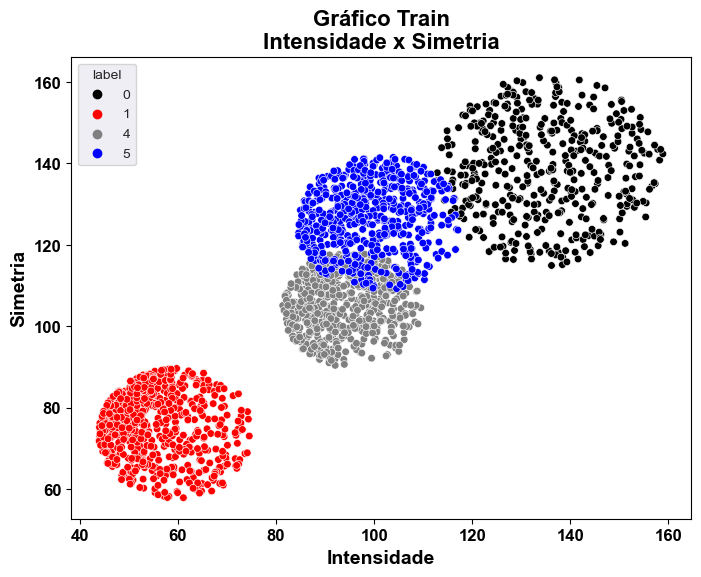

In [12]:
plots(df_train, [0, 1, 4, 5], 'Gráfico Train\nIntensidade x Simetria')

#### Test_redu.csv

In [13]:
df_test = pd.read_csv("data/test_redu.csv")
df_test

,label,intensidade,simetria
0,0,147.933333,130.470588
1,0,131.054902,122.721569
2,0,134.890196,151.725490
3,0,139.976471,133.921569
4,0,129.580392,130.274510
...,...,...,...
1110,5,96.121569,139.521569
1111,5,98.439216,130.729412
1112,5,95.141176,122.227451
1113,5,106.882353,128.007843


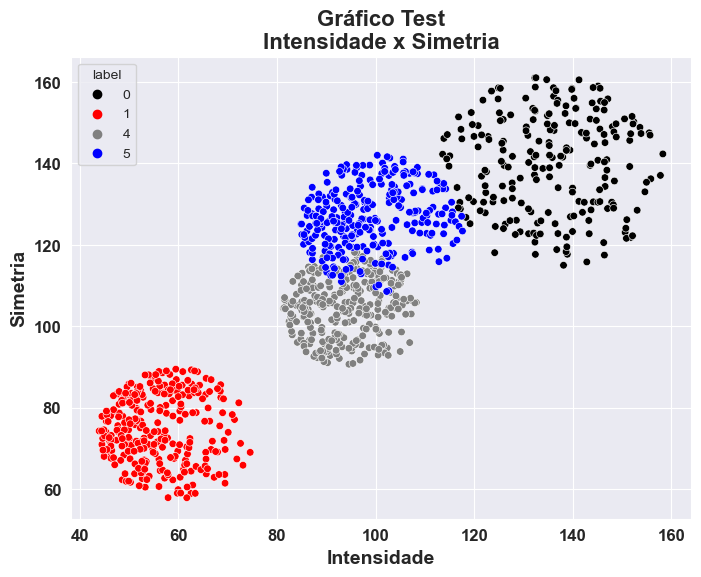

In [14]:
plots(df_test, [0, 1, 4, 5], 'Gráfico Test\nIntensidade x Simetria')

### Modelos de Aprendizagem de Máquina(AM) estudados

## Classificação dos dígitos 1 x 5

Lê os arquivos train_redu.csv e test_redu.csv

In [15]:
train_redu = pd.read_csv('data/train_redu.csv')
test_redu = pd.read_csv('data/test_redu.csv')

Filtra as imagens com label igual a 1 ou 5

In [16]:
label1 = train_redu[train_redu.label == 1]
label5 = train_redu[train_redu.label == 5]

label1_test = test_redu[test_redu.label == 1]
label5_test = test_redu[test_redu.label == 5]

In [17]:
train1x5 = pd.concat([label1, label5], axis=0)
test1x5 = pd.concat([label1_test, label5_test], axis=0)

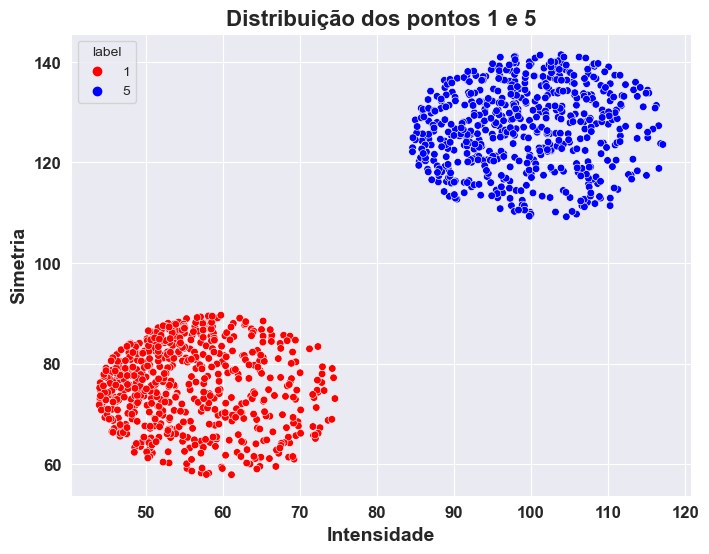

In [18]:
plot1x5(train1x5, [1, 5], 'Distribuição dos pontos 1 e 5')

In [19]:
# plt.figure(figsize=(10, 6))

# sns.scatterplot(x='intensidade', y='simetria', hue='label', data=train1x5, palette=['red', 'blue'], marker='o')

# # define as labels e tamanho/fonte
# plt.xlabel('Intensidade', fontsize=14, fontweight='bold')
# plt.ylabel('Simetria', fontsize=14, fontweight='bold')
# plt.title('Distribuição dos pontos 1 e 5', fontsize=16, fontweight='bold')

# # define o tamanho/fonte das tick labels
# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')

# plt.show()

In [20]:
X_train = train1x5[['intensidade', 'simetria']]
X_train = X_train.to_numpy()
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = test1x5[['intensidade', 'simetria']]
X_test = X_test.to_numpy()
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

y_train = [1 if label == 1 else -1 for label in train1x5.label]
y_test = [1 if label == 1 else -1 for label in test1x5.label]

#### Perceptron 1x5

In [58]:
n_min = np.ceil(X_train.shape[0] * 0.3).astype(int)
n_max = np.ceil(X_train.shape[0] * 0.7).astype(int) 

pocket_pla = PocketPLA(10000, n_min=n_min, n_max=n_max)
pocket_pla.fit(X_train, y_train)
y_pred = pocket_pla.predict(X_test)
w_pocket = pocket_pla.get_w()

100%|██████████| 10000/10000 [00:14<00:00, 673.92it/s]


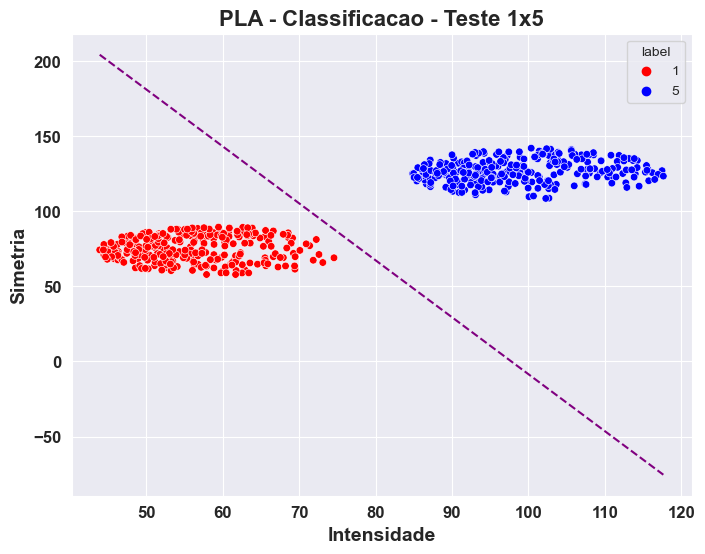

In [59]:
plot1x5(test1x5, [1, 5], 'PLA - Classificacao - Teste 1x5', W=[w_pocket])

Matriz de confusão do PLA:


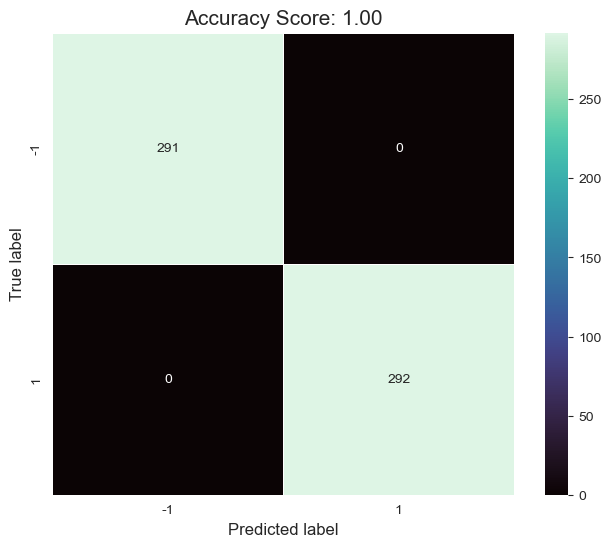



Métricas do PLA:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



In [60]:
digits_list = [1, 5]
metrics = all(digits_list)
print("Matriz de confusão do PLA:")
metrics.plot_cm(y_test, y_pred)
print("\n")
print("Métricas do PLA:")
print(classification_report(y_test, y_pred))

#### Regressão Linear 1x5

In [24]:
r_linear = LinearRegression()
r_linear.fit(X_train, y_train)
y_pred = r_linear.predict(X_test)
w_lin = r_linear.get_w()

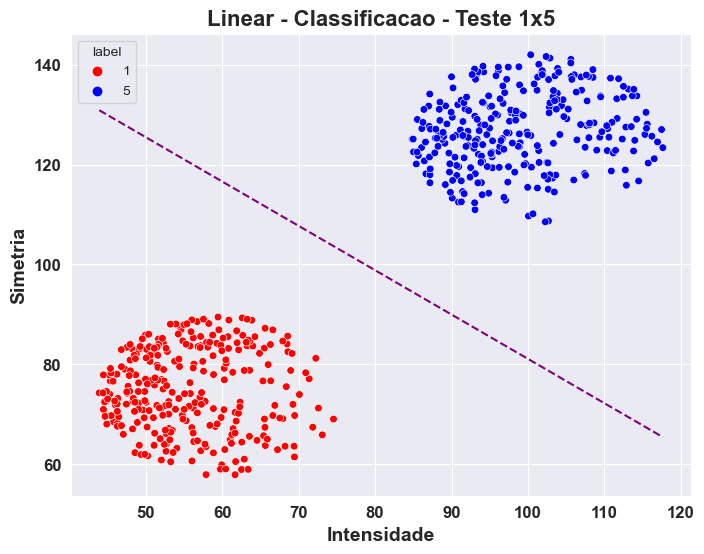

In [25]:
plot1x5(test1x5, [1, 5], 'Linear - Classificação - Teste 1x5', W=[w_lin])

Matriz confusão da Regressão Linear:


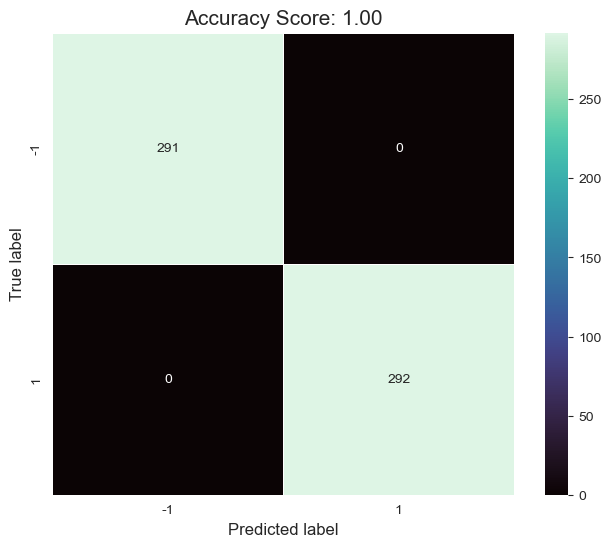



Métricas da Regressão Linear:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



In [26]:
digits_list = [1, 5]
metrics = all(digits_list)
print("Matriz confusão da Regressão Linear:")
metrics.plot_cm(y_test, y_pred)
print("\n")
print("Métricas da Regressão Linear:")
print(classification_report(y_test, y_pred))

#### Regressão Logística 1x5

In [82]:
r_logistic = LogisticRegression(iter=80000, batch_size=512)
r_logistic.fit(X_train, y_train)
y_pred = r_logistic.predict(X_test)
w_logistic = r_logistic.get_w()

  0%|          | 0/80000 [00:00<?, ?it/s]c:\Users\tales\miniprojeto\models.py:113: RuntimeWarning: overflow encountered in exp
  sigm = 1 / (1 + np.exp(y_batch * np.dot(w, X_batch.T).reshape(-1, 1)))
100%|██████████| 80000/80000 [00:08<00:00, 9837.31it/s] 


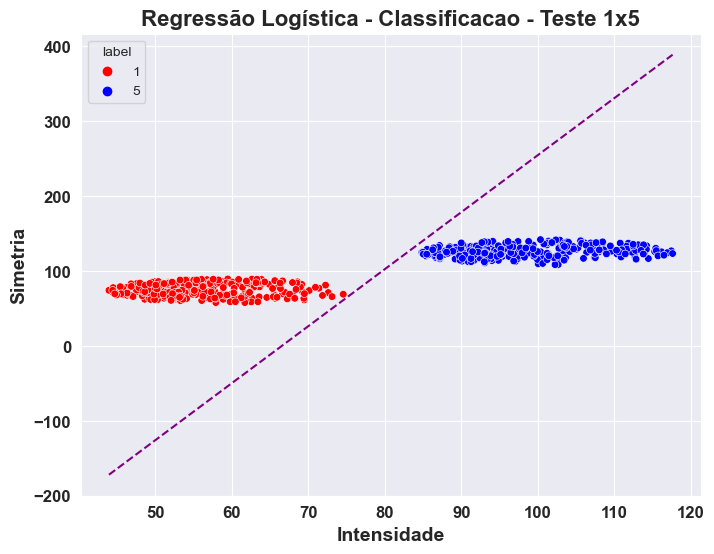

In [83]:
plot1x5(test1x5, [1, 5], 'Regressão Logística - Classificacao - Teste 1x5', W=[w_logistic])

Matriz confusão da Regressão Logística:


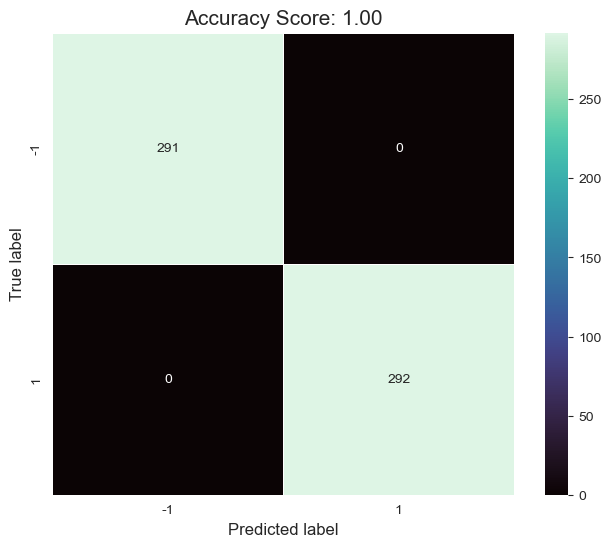



Métricas da Regressão Logística:
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       291
           1       1.00      1.00      1.00       292

    accuracy                           1.00       583
   macro avg       1.00      1.00      1.00       583
weighted avg       1.00      1.00      1.00       583



In [84]:
digits_list = [1, 5]
metrics = all(digits_list)
print("Matriz confusão da Regressão Logística:")
metrics.plot_cm(y_test, y_pred)
print("\n")
print("Métricas da Regressão Logística:")
print(classification_report(y_test, y_pred))

#

## One vs all